# Validation of spectral flux density calculation

By Berlin

## Visualizing spectral flux densities corresponding to stars in EXOCAT:

In [33]:
import os, warnings, astropy
os.path.exists('EXOSIMS/StarCatalog/mission_exocat_2019.08.22_11.37.24.votable')
from astropy.io.votable import parse
catalogpath = 'EXOSIMS/StarCatalog/mission_exocat_2019.08.22_11.37.24.votable'
with warnings.catch_warnings():
    # warnings for IPAC votables are out of control 
    #   they are not moderated by pedantic=False
    #   they all have to do with units, which we handle independently anyway
    warnings.simplefilter('ignore', 
            astropy.io.votable.exceptions.VOTableSpecWarning)
    warnings.simplefilter('ignore', 
            astropy.io.votable.exceptions.VOTableChangeWarning)
    votable = parse(catalogpath)
table = votable.get_first_table()
data = table.array

names, Vmag, BV, specs = data['hip_name'], data['st_vmag'], data['st_bmv'], data['st_spttype'].astype(str)

# names, Vmag, BV, specs  = sim.TargetList.Name, sim.TargetList.Vmag, sim.TargetList.BV, sim.TargetList.Spec
# names, Vmag, BV, specs = list(names), list(V), list(BV), list(specs)

We compute the spectral flux density using the the Traub et al. way (`F0_Traubetal`) and the spectral-type matchup way (`F0_spec`): 

In [40]:
import numpy as np
import astropy.units as u
from spec_flux_dens_util import calc_F0_Traubetal, calc_F0

LAMBDA = 1200 * u.nm
BW = 0.2

lamb, bw = np.ones(len(names))*LAMBDA, np.ones(len(names))*BW

F0_Traubetal = list(map(calc_F0_Traubetal, Vmag, BV, lamb))
F0_spec = list(map(calc_F0, lamb, bw, Vmag, BV, specs))

In [5]:
''' Comment out the print statements below to peak inside F0_Traubetal and F0_spec

print('Star name \t F0 with spectral type matchup \t\t F0 with Traub et al')
print('--------------------------------------------------------------------------')

for i, name in enumerate(names):
    print(name, '\t', F0_spec[i], '\t', F0_Traubetal[i])
    
'''

Generating the scatterplot:

/Users/berlinc/anaconda2/envs/es/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/berlinc/anaconda2/envs/es/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


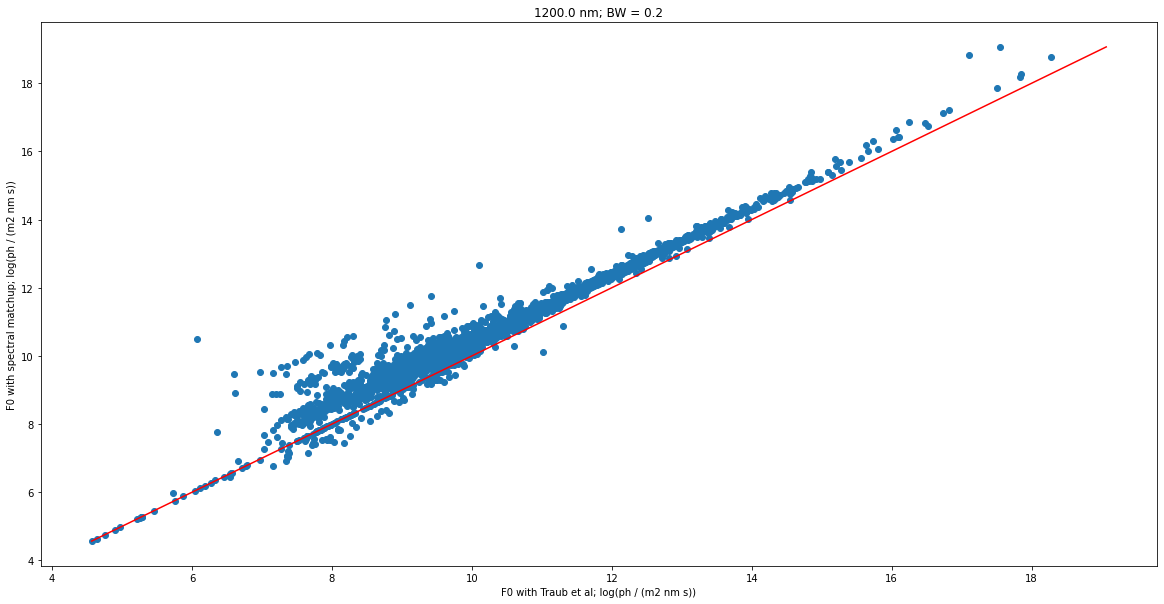

In [41]:
import numpy as np
import matplotlib.pyplot as plt

x = np.log([f0.value for f0 in F0_Traubetal])
y = np.log([f0.value for f0 in F0_spec])

ninf = -float('inf')
vmin, vmax = min(np.min(x[x != ninf]), np.min(y[y != ninf])), max(np.max(x), np.max(y))

plt.figure(figsize=(20, 10))
plt.scatter(x, y)
plt.plot([vmin, vmax], [vmin, vmax], color='red')
plt.title(str(LAMBDA) + '; BW = ' + str(BW))
plt.xlabel('F0 with Traub et al; log(ph / (m2 nm s))')
plt.ylabel('F0 with spectral matchup; log(ph / (m2 nm s))')
# plt.show()
plt.savefig(str(int(LAMBDA.value)) + 'nm_BW' + str(BW).replace('.', 'p') + '_EXOCAT.png', dpi=300)

## Using Existing `sim.TargetList.F0()` Method

In [42]:
import EXOSIMS,EXOSIMS.MissionSim,os.path
scriptfile = '/Users/berlinc/Documents/exosims/EXOSIMS_fork/EXOSIMS/Scripts/HabEx_4m_coroOnly_DulzE_promo_EPRVmwants_lucky_charAsnr5_binMenn_20190929_mod.json'
sim = EXOSIMS.MissionSim.MissionSim(scriptfile)

In [22]:
import numpy as np
import astropy.units as u
import pandas as pd

LAMBDA_list = [500 * u.nm, 625 * u.nm, 910 * u.nm]
BW = [0.2, 0.2, 0.088]

df = pd.DataFrame()

for curr_lambda, curr_bw in zip(LAMBDA_list, BW):
    lamb, bw = np.ones(len(names))*curr_lambda, np.ones(len(names))*curr_bw
    curr_F0_Traubetal = list(map(sim.TargetList.F0, bw, lamb))
    curr_F0_spec = list(map(sim.TargetList.F0, bw, lamb, specs))
    curr_F0_Traubetal = np.array([f0.value for f0 in curr_F0_Traubetal])
    curr_F0_spec = np.array([f0.value for f0 in curr_F0_spec])
    curr_df = pd.DataFrame({'lambda': lamb,
                            'F0_Traubetal': curr_F0_Traubetal,
                            'F0_spec': curr_F0_spec,
                            'F0_Traubetal-F0_spec': curr_F0_Traubetal - curr_F0_spec})
    df = df.append(curr_df)
    
print(df.head(10))

   lambda  F0_Traubetal       F0_spec  F0_Traubetal-F0_spec
0   500.0  1.188325e+08  8.733969e+07          3.149276e+07
1   500.0  1.188325e+08  7.603972e+07          4.279273e+07
2   500.0  1.188325e+08  9.570079e+07          2.313166e+07
3   500.0  1.188325e+08  7.275150e+07          4.608096e+07
4   500.0  1.188325e+08  1.188325e+08          0.000000e+00
5   500.0  1.188325e+08  9.279827e+07          2.603418e+07
6   500.0  1.188325e+08  7.006982e+07          4.876263e+07
7   500.0  1.188325e+08  7.603972e+07          4.279273e+07
8   500.0  1.188325e+08  7.006982e+07          4.876263e+07
9   500.0  1.188325e+08  8.733969e+07          3.149276e+07


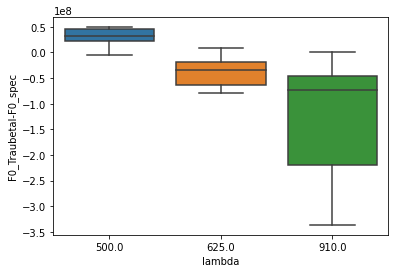

In [25]:
import seaborn as sns
ax = sns.boxplot(x="lambda", y="F0_Traubetal-F0_spec", data=df, showfliers=False)